In [1]:
!pip install kmodes

In [35]:
from pyspark.sql import SparkSession, functions as F, types as T
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA, IndexToString
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
from kmodes.kprototypes import KPrototypes
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [3]:
spark = SparkSession.builder \
    .appName("SpotifyClustering") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

In [4]:
path = "hdfs://namenode:9000/spotify/clean_data"

# 1) Read with header, no schema (but robust CSV options)
df0 = (spark.read
       .option("header", True)
       .option("multiLine", True)
       .option("quote", '"')
       .option("escape", '"')
       .option("mode", "PERMISSIVE")
       .csv(path))

print(df0.columns)      
#df0.show(3, truncate=False)

# 2) Cast columns by NAME (not by position)
cast_to = {
    "popularity": "int",
    "duration_ms": "int",
    "explicit": "boolean",   
    "danceability": "double",
    "energy": "double",
    "key": "int",
    "loudness": "double",
    "mode": "int",
    "speechiness": "double",
    "acousticness": "double",
    "instrumentalness": "double",
    "liveness": "double",
    "valence": "double",
    "tempo": "double",
    "time_signature": "int",
    "track_genre": "string",
}

df = df0.select(*[
    F.col(c).cast(cast_to[c]).alias(c) if c in cast_to else F.col(c)
    for c in df0.columns
])
df = df.na.drop(subset=df.columns)

['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'explicit_int']


We initially wanted to use Kmeans to cluster our data. However since we have more categorical and numeric data, using kmeans would mean that we have to drop a lot of information. Instead, we decided to use kprototype to be able to keep both datatype. However, Kprototype is not implemented in spark so we nee to use pandas. 

In [5]:
# We want to cluster the music by their characteristic so we will remove some columns
print(df.columns)
df_2 = df.drop(df.track_id, df.album_name, df.track_name, df.artists, df.explicit)
df_2.show()
print(df_2.columns)

['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre', 'explicit_int']
+----------+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-------------+------------+
|popularity|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|  track_genre|explicit_int|
+----------+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+-------------+------------+
|        14|      56200|       0.268| 0.968|  4| -11.194|   1|      0.102|     0.00435|           0.779|    0.37|  0.402| 107.06|             4|    grindcore|           0|
|         0|     143771|       0.4

Let's look at the number of unique genre

In [6]:
num_unique = df_2.select("track_genre").distinct().count()
print("There is", num_unique,"genres.")

There is 113 genres.


In [34]:
# We separate the continuous and discrete columns
cat_columns = ["track_genre", "explicit_int", "time_signature", "mode", "key"]
num_columns = df_2.columns
for name in cat_columns :
    num_columns.remove(name)

# We are going to normalize the columns which are continuous
for c in num_columns:
    stats = df_2.select(F.mean(c).alias("mean"), F.stddev(c).alias("std")).first()
    mean_val = stats["mean"]
    std_val = stats["std"]
    df_2 = df_2.withColumn(c, (F.col(c) - F.lit(mean_val)) / F.lit(std_val))

# We need to encode the columns that are categorical
# key, mode and time_signature are already encoded
# We need to convert explicit_int to int because it is currently a string
df_2 = df_2.withColumn("explicit_int", df_2["explicit_int"].cast(IntegerType()))

#We encode track_genre
indexer = StringIndexer(inputCol="track_genre", outputCol="genre_index")
df_2 = indexer.fit(df_2).transform(df_2)
df_indexed = df_2.drop("track_genre")
cat_columns.remove("track_genre")
cat_columns.append("genre_index")

df_indexed.dtypes

[('popularity', 'double'),
 ('duration_ms', 'double'),
 ('danceability', 'double'),
 ('energy', 'double'),
 ('key', 'int'),
 ('loudness', 'double'),
 ('mode', 'int'),
 ('speechiness', 'double'),
 ('acousticness', 'double'),
 ('instrumentalness', 'double'),
 ('liveness', 'double'),
 ('valence', 'double'),
 ('tempo', 'double'),
 ('time_signature', 'int'),
 ('explicit_int', 'int'),
 ('genre_index', 'double')]

Let's proceed with the clustering

In [47]:
data = df_indexed.toPandas()

costs = []
K = range(2, 11)  
cat_cols = [data.columns.get_loc(c) for c in cat_columns]

for k in K:
    print("k =",k)
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=1, random_state=42, max_iter=20, n_init=1)
    clusters = kproto.fit_predict(data, categorical=cat_cols)
    costs.append(kproto.cost_)

k = 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 20297, ncost: 937951.7532408079
Run: 1, iteration: 2/20, moves: 12731, ncost: 916782.1827762886
Run: 1, iteration: 3/20, moves: 5304, ncost: 912822.188272936
Run: 1, iteration: 4/20, moves: 2136, ncost: 912105.4904234305
Run: 1, iteration: 5/20, moves: 939, ncost: 911947.6200488681
Run: 1, iteration: 6/20, moves: 404, ncost: 911919.7710239355
Run: 1, iteration: 7/20, moves: 140, ncost: 911916.2256969208
Run: 1, iteration: 8/20, moves: 60, ncost: 911915.5808445655
Run: 1, iteration: 9/20, moves: 15, ncost: 911915.5364065662
Run: 1, iteration: 10/20, moves: 4, ncost: 911915.5321869986
Run: 1, iteration: 11/20, moves: 2, ncost: 911915.5312087131
Run: 1, iteration: 12/20, moves: 1, ncost: 911915.5305484404
Run: 1, iteration: 13/20, moves: 1, ncost: 911915.5299273102
Run: 1, iteration: 14/20, moves: 

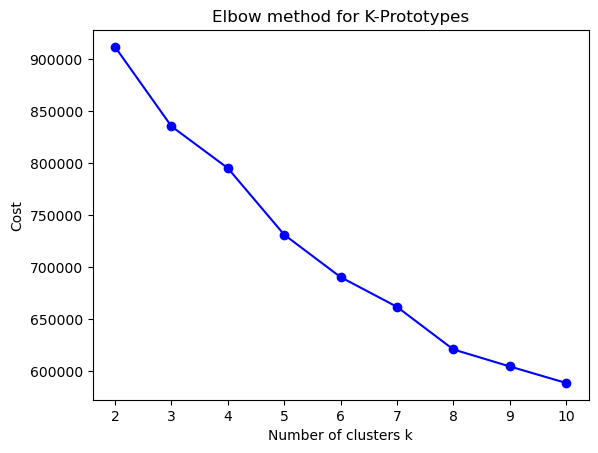

In [50]:
# Plot the elbow
import matplotlib.pyplot as plt
plt.plot(K, costs, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Cost')
plt.title('Elbow method for K-Prototypes')
plt.show()

We can pick k=5 since there is quite a steep decrease between 4 and 5. But it's quite difficult to use the elbow rule with this plot. 

In [51]:
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=1, random_state=42, max_iter=50, n_init=2)
clusters = kproto.fit_predict(data, categorical=cat_cols)
data["clusters"] = clusters

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/50, moves: 36878, ncost: 771589.7166595767
Run: 1, iteration: 2/50, moves: 17260, ncost: 754665.9209589731
Run: 1, iteration: 3/50, moves: 11720, ncost: 742757.5966604415
Run: 1, iteration: 4/50, moves: 8697, ncost: 734611.498221759
Run: 1, iteration: 5/50, moves: 4681, ncost: 731652.4291421383
Run: 1, iteration: 6/50, moves: 1740, ncost: 731252.3197478583
Run: 1, iteration: 7/50, moves: 512, ncost: 731218.5675816258
Run: 1, iteration: 8/50, moves: 212, ncost: 731213.9690933411
Run: 1, iteration: 9/50, moves: 105, ncost: 731212.9462865763
Run: 1, iteration: 10/50, moves: 58, ncost: 731212.6045277291
Run: 1, iteration: 11/50, moves: 38, ncost: 731212.415698596
Run: 1, iteration: 12/50, moves: 28, ncost: 731212.3312933431
Run: 1, iteration: 13/50, moves: 26, ncost: 731212.2155065266
Run: 1, iteration: 14/50, moves

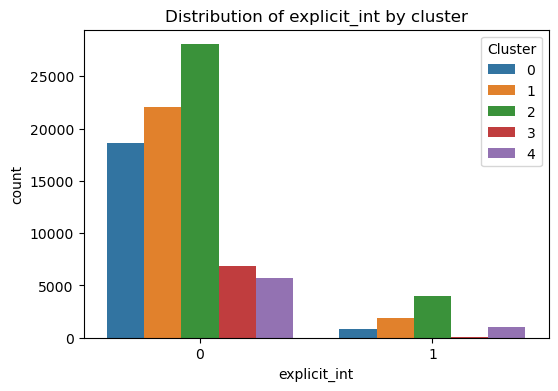

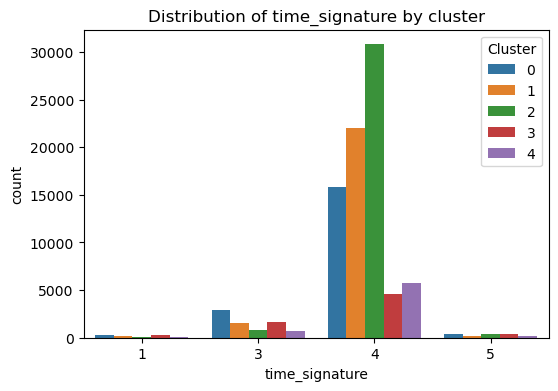

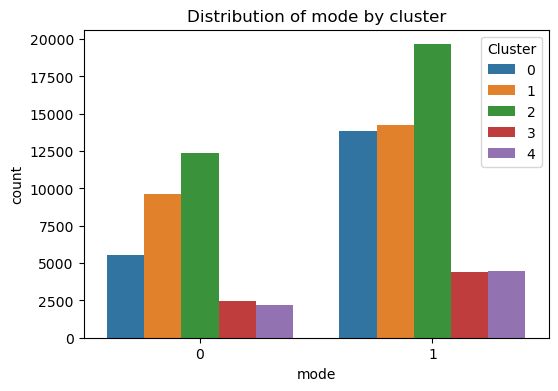

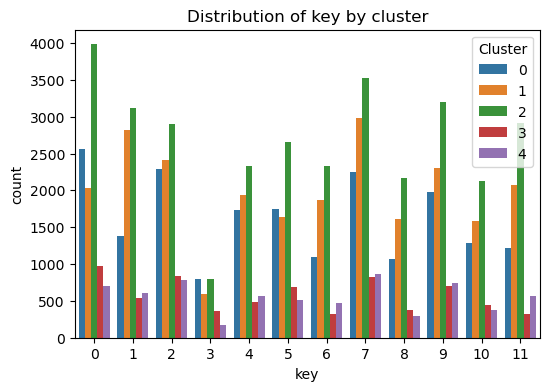

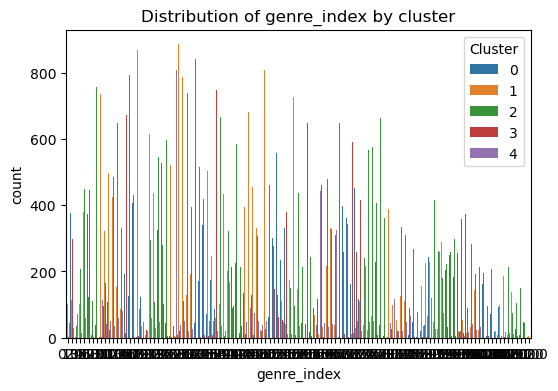

In [52]:
for col in cat_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x=col, hue='clusters', palette='tab10')
    plt.title(f'Distribution of {col} by cluster')
    plt.legend(title='Cluster')
    plt.show()

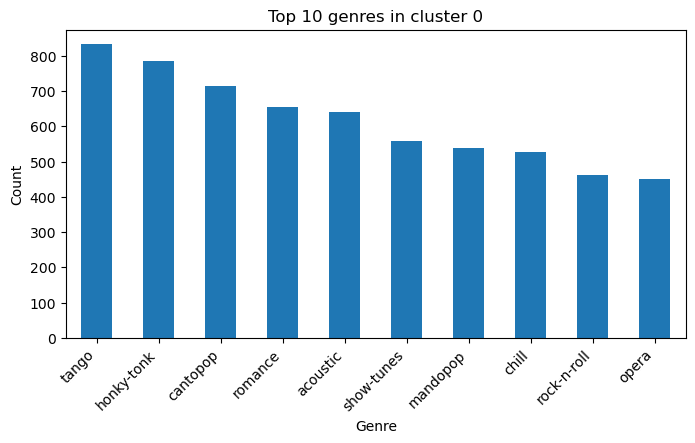

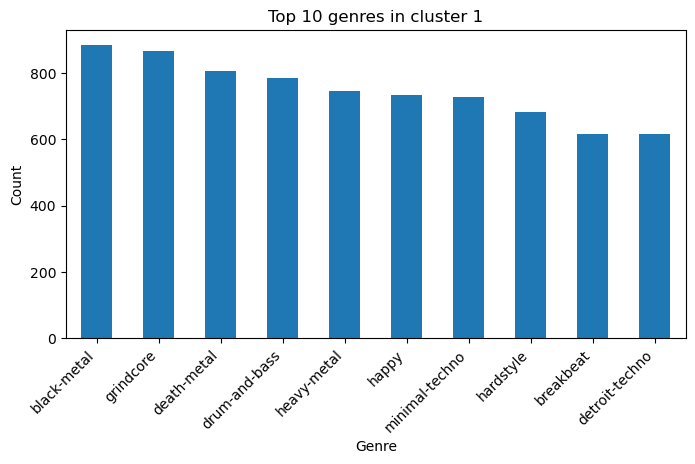

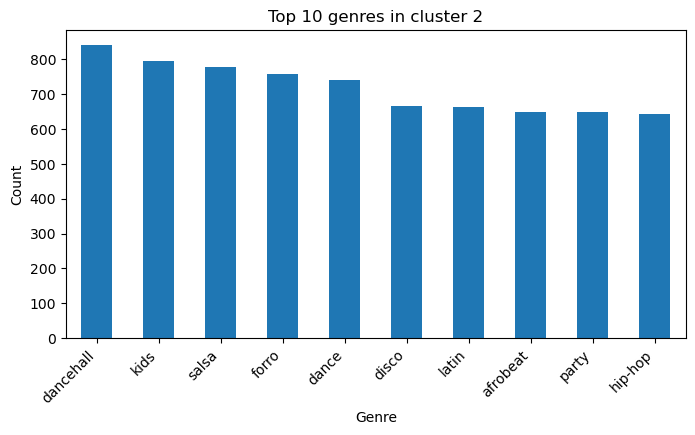

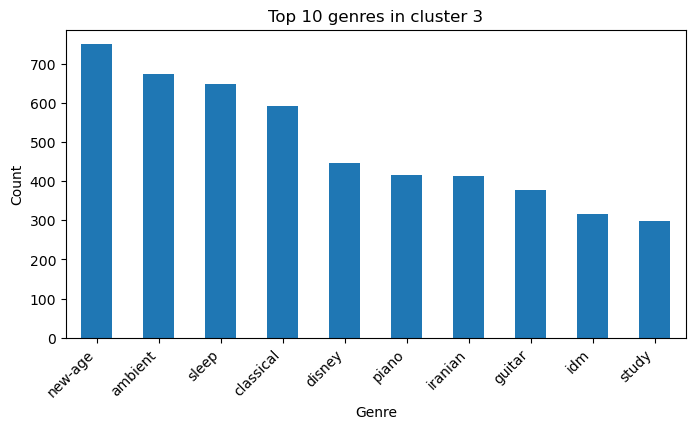

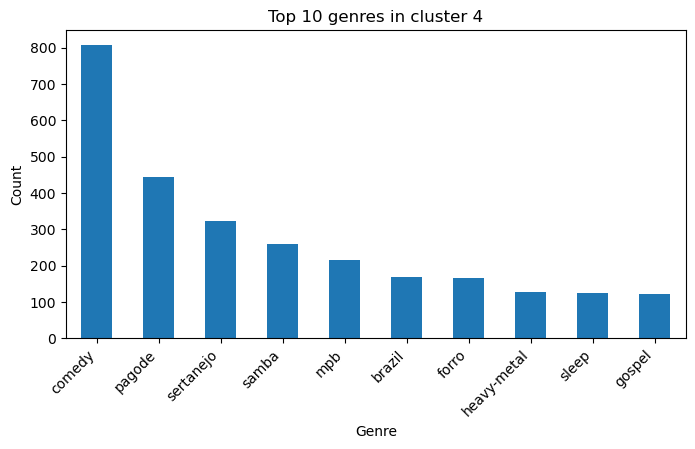

In [53]:
mapping = dict(df_2.select("genre_index", "track_genre").distinct().collect())
data["track_genre"] = data["genre_index"].map(mapping)
top_n = 10  # number of top genres to show

for cluster_id in sorted(data['clusters'].unique()):
    top_genres = (
        data[data['clusters'] == cluster_id]['track_genre']
        .value_counts()
        .head(top_n)
    )

    plt.figure(figsize=(8, 4))
    top_genres.plot(kind='bar')
    plt.title(f"Top {top_n} genres in cluster {cluster_id}")
    plt.ylabel("Count")
    plt.xlabel("Genre")
    plt.xticks(rotation=45, ha='right')
    plt.show()

   popularity  duration_ms  danceability    energy  loudness  speechiness  \
0    0.031504    -0.188354     -0.128653 -0.981276 -0.275672    -0.347853   
1   -0.076827     0.510392     -0.430704  0.658477 -0.088477     0.376886   
2    0.089217    -0.230800      0.689844  0.388007  0.060968    -0.401111   
3   -0.248605    -0.183387     -1.154505 -1.761247 -0.304068     1.876848   
4    0.009813     0.019219     -0.214733  0.441717  1.137871    -0.336905   

   acousticness  instrumentalness  liveness  valence  tempo  
0     -0.281715         -0.241482 -0.291682      0.0    4.0  
1     -0.127178         -0.608472  0.441765      0.0    4.0  
2     -0.235340          0.812258 -0.020669      0.0    4.0  
3     -0.312883         -1.077139 -0.562150      0.0    4.0  
4      2.727672          0.081692 -0.055723      0.0    4.0  


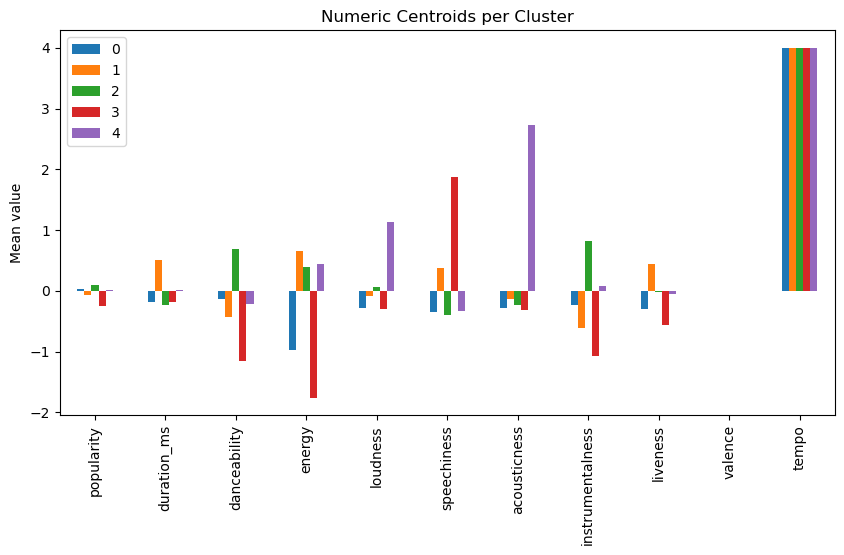

In [79]:

num_cols = [i for i in range(0,16)]
for n in cat_cols :
    num_cols.remove(n)
    

centroids = pd.DataFrame(kproto.cluster_centroids_[:,num_cols], columns=data.columns[num_cols])
print(centroids)

centroids.T.plot(kind='bar', figsize=(10, 5))
plt.title('Numeric Centroids per Cluster')
plt.ylabel('Mean value')
plt.show()

If we still want to do the Kmeans, we can do so by removing the categorical features.

In [80]:
# We need to convert the columns of the df to feature vectors
assembler = VectorAssembler(inputCols=num_columns, outputCol="features")
df_features = assembler.transform(df_indexed)

In [81]:
# We use the elbow method to chose the number of cluster
inertia = []
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='features', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')
list_k = [k for k in range(2,11)]
for k in list_k :
    kmeans = KMeans(k = k, seed = 42)
    model = kmeans.fit(df_features)
    inertia.append(model.summary.trainingCost)
    df_temp = model.transform(df_features)
    score=evaluator.evaluate(df_temp)
    silhouette_score.append(score)

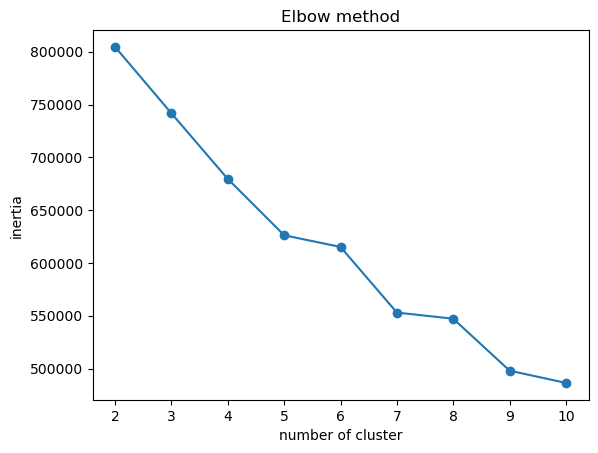

In [82]:
plt.plot(list_k, inertia,"o-")
plt.xlabel("number of cluster")
plt.ylabel("inertia")
plt.title("Elbow method")
plt.show()

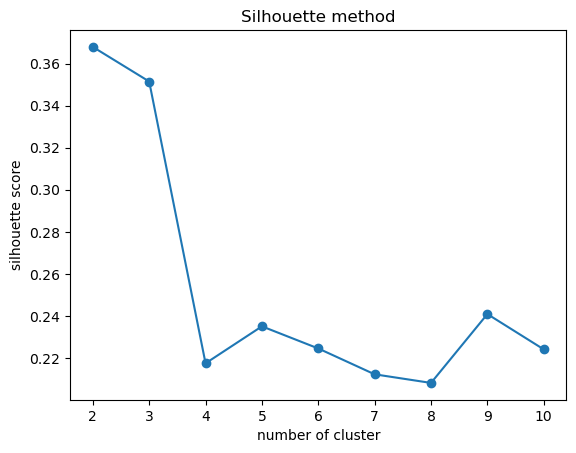

In [83]:
plt.plot(list_k, silhouette_score,"o-")
plt.xlabel("number of cluster")
plt.ylabel("silhouette score")
plt.title("Silhouette method")
plt.show()

We choose a number of cluster of 5 because for the elbow plot, the decrease between k=5 and k=6 is not as steep. Furthermore, for the silhouette plot, the silhouette score goes up for 5 and then goes down again so it's a local maximum. We could also tried k=9 for the same reasons. 

In [84]:
kmeans = KMeans(k = 5, seed = 42)
model = kmeans.fit(df_features)
df_labeled = model.transform(df_features)

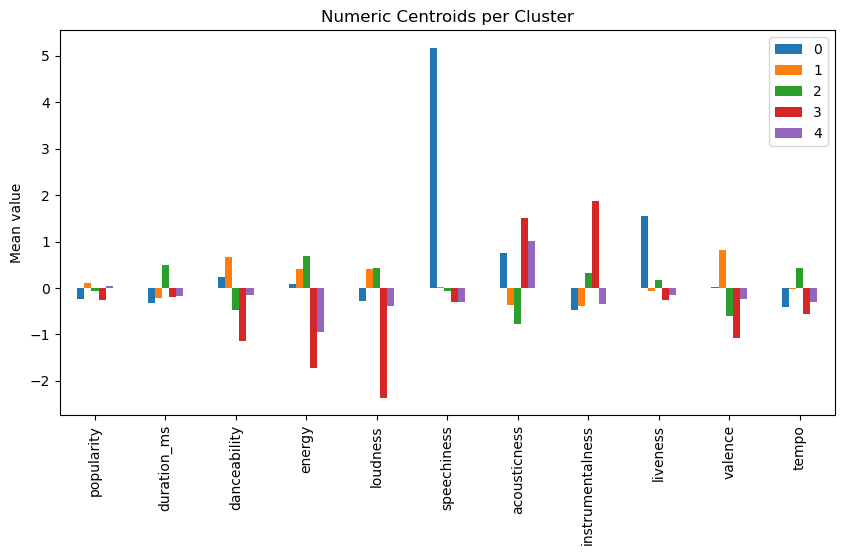

In [87]:

centroids = model.clusterCenters()
df_centroids = pd.DataFrame(centroids, columns=num_columns)

df_centroids.T.plot(kind='bar', figsize=(10, 5))
plt.title('Numeric Centroids per Cluster')
plt.ylabel('Mean value')
plt.show()

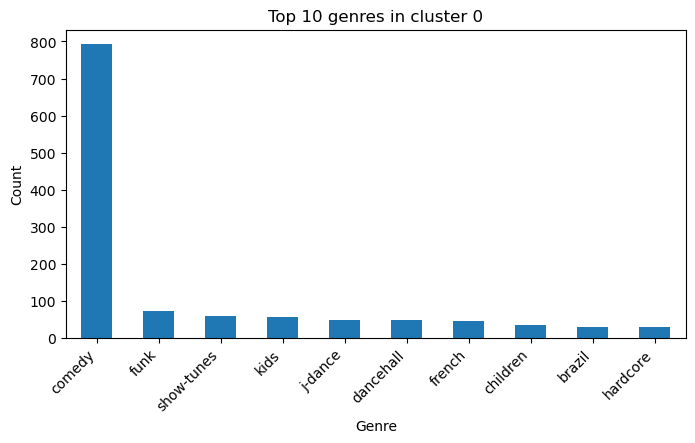

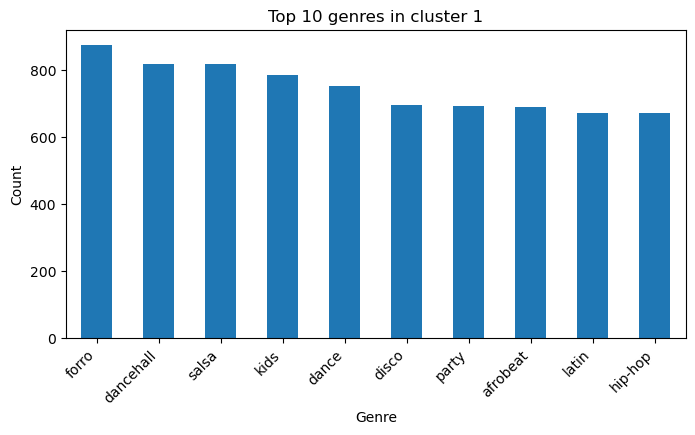

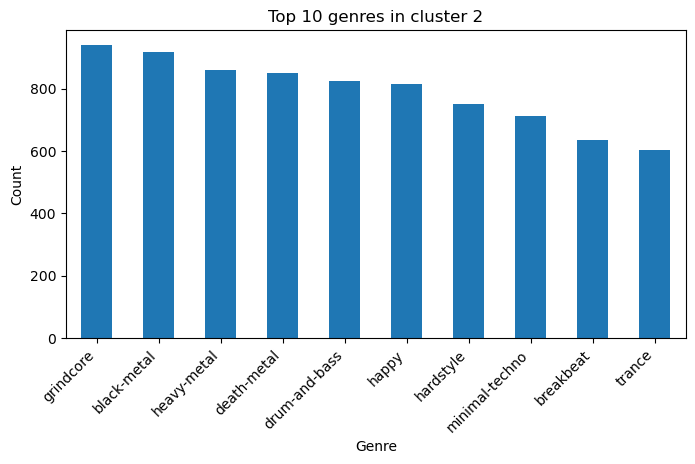

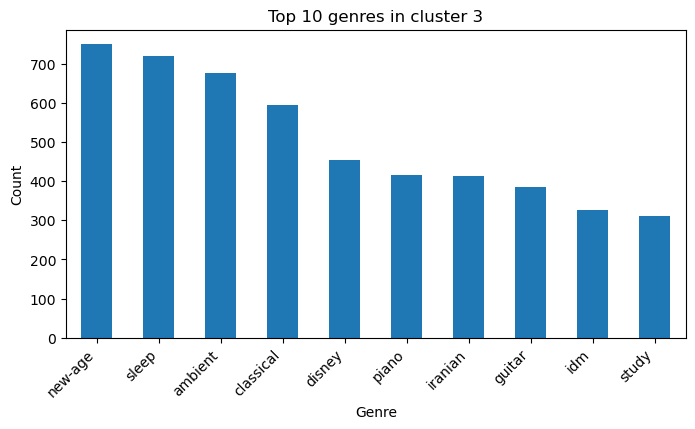

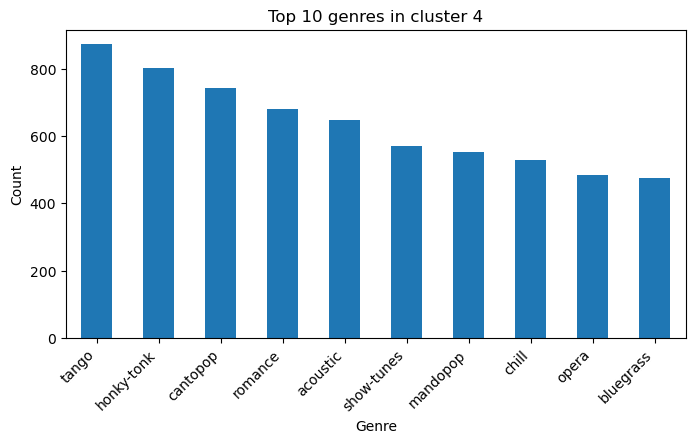

In [91]:
mapping = dict(df_2.select("genre_index", "track_genre").distinct().collect())
top_n = 10  # number of top genres to show
data_bis = df_labeled.toPandas()
data_bis["track_genre"] = data_bis["genre_index"].map(mapping)

for cluster_id in sorted(data_bis['prediction'].unique()):
    top_genres = (
        data_bis[data_bis['prediction'] == cluster_id]['track_genre']
        .value_counts()
        .head(top_n)
    )

    plt.figure(figsize=(8, 4))
    top_genres.plot(kind='bar')
    plt.title(f"Top {top_n} genres in cluster {cluster_id}")
    plt.ylabel("Count")
    plt.xlabel("Genre")
    plt.xticks(rotation=45, ha='right')
    plt.show()